## 6. Mom + Hedge

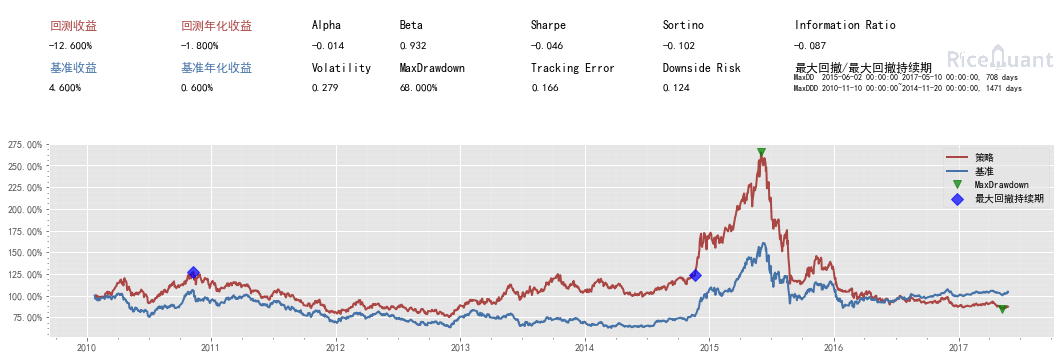

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2010-01-25  2657.96    9997342.04                  1.000  10000000.00   
  2010-01-26  2657.96    9741371.20                  1.000   9744029.16   
  2010-01-27  2657.96    9608504.28                  0.974   9611162.24   
  2010-01-28  2657.96    9632536.28                  0.961   9635194.24   
  2010-01-29  2657.96    9625296.64                  0.964   9627954.60   
  2010-02-01  2657.96    9470740.84                  0.963   9473398.80   
  2010-02-02  2657.96    9451154.76                  0.947   9453812.72   
  2010-02-03  2657.96    9705082.88                  0.945   9707740.84   
  2010-02-04  2657.96    9669275.20                  0.971   9671933.16   
  2010-02-05  2657.96    9471882.36                  0.967   9474540.32   
  2010-02-08  2657.96    9465573.96                  0.947   

In [7]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *

def init(context):
    codes = pd.read_excel('D:/PycharmProjects/Quant_Alpha/Momentun_Hedge/mom_Selection.xlsx')
    codes.index = codes.pop('date')
    context.codes = codes
    scheduler.run_weekly(find_pool, tradingday=1)

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now]
    stocks = codes.index[codes == True]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)

        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            data_c = history_bars(codes, 25, '1d', 'close', adjust_type='post')
            ma = ta.EMA(data_c, timeperiod=20)
            if len(ma)>3:
                if ma[-1] > ma[-2] and ma[-2] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                    result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

def sell(context):
    sell_list = []
    for stocks in context.portfolio.positions:
        data_c = history_bars(stocks, 25, '1d', 'close', adjust_type='post')
        ma = ta.EMA(data_c, timeperiod=20)
        ma_s = ta.EMA(data_c, timeperiod=10)
        if len(ma)>3:
            if ma[-1] < ma[-2] and ma[-2] < ma[-3]:
                sell_list.append(stocks)
    if len(sell_list):
        for s in sell_list:
            order_target_percent(s, 0)


"""

config = {
    "base": {
        "start_date": "2010-01-25",
        "end_date": "2017-05-30",
        "frequency": '1d',
        "securities": ['stock'],
        "stock_starting_cash": 10000000,
        "benchmark": "000300.XSHG"
    },
    "extra": {
        "log_level": "verbose",
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True
        }
    }
}

run_code(code, config)

## MOM_EMPTY

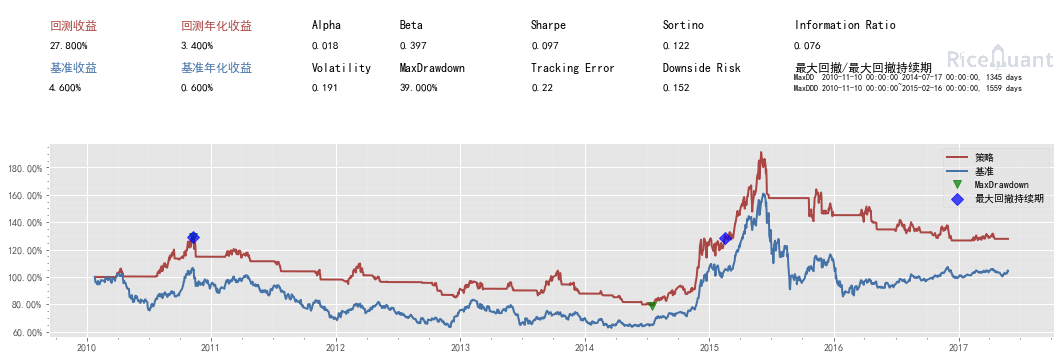

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2010-01-25  2657.96    9997342.04                  1.000  10000000.00   
  2010-01-26  2657.96    9741371.20                  1.000   9744029.16   
  2010-01-27  2657.96    9608504.28                  0.974   9611162.24   
  2010-01-28  2657.96    9632536.28                  0.961   9635194.24   
  2010-01-29  2657.96    9625296.64                  0.964   9627954.60   
  2010-02-01  2657.96    9470740.84                  0.963   9473398.80   
  2010-02-02  2657.96    9451154.76                  0.947   9453812.72   
  2010-02-03  2657.96    9705082.88                  0.945   9707740.84   
  2010-02-04  2657.96    9669275.20                  0.971   9671933.16   
  2010-02-05  2657.96    9471882.36                  0.967   9474540.32   
  2010-02-08  2657.96    9465573.96                  0.947   

In [13]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *
from fxdayu_data import DataAPI

def init(context):
    codes = pd.read_excel('D:/PycharmProjects/Quant_Alpha/Momentun_Hedge/mom_Selection.xlsx')
    codes.index = codes.pop('date')
    context.codes = codes
    scheduler.run_weekly(find_pool, tradingday=1)
    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')
    df = DataAPI.candle('sh000001', 'D')
    df['P_V'] = df.close*df.volume
    df['MA_hedge'] = ta.abstract.SUM(df, 50, price='P_V')/ta.abstract.SUM(df,50, price='volume')
    context.df = df

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now]
    stocks = codes.index[codes == True]
    context.stocks = stocks


def handle_bar(context, bar_dict):
    sell(context)
    if can_trade(context):
        buy(context, bar_dict)


def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            data_c = history_bars(codes, 25, '1d', 'close', adjust_type='post')
            ma = ta.EMA(data_c, timeperiod=20)
            if len(ma)>3:
                if ma[-1] > ma[-2] and ma[-2] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                    result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

def sell(context):
    sell_list = []
    for stocks in context.portfolio.positions:
        data_c = history_bars(stocks, 25, '1d', 'close', adjust_type='post')
        ma = ta.EMA(data_c, timeperiod=20)
        ma_s = ta.EMA(data_c, timeperiod=10)
        if len(ma)>3:
            if ma[-1] < ma[-2] and ma[-2] < ma[-3]:
                sell_list.append(stocks)
    if len(sell_list):
        for s in sell_list:
            order_target_percent(s, 0)

def sell_all(context):
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)

def can_trade(context):
    if context.df.close.loc[context.now] < context.df.MA_hedge.loc[context.now]:
        sell_all(context)
        return False
    else:
        return True
"""

config = {
    "base": {
        "start_date": "2010-01-25",
        "end_date": "2017-05-30",
        "frequency": '1d',
        "securities": ['stock'],
        "stock_starting_cash": 10000000,
        "benchmark": "000300.XSHG"
    },
    "extra": {
        "log_level": "verbose",
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True
        }
    }
}

run_code(code, config)

## MOM_Hedge

In [ ]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *
from fxdayu_data import DataAPI

def init(context):
    codes = pd.read_excel('D:/PycharmProjects/Quant_Alpha/Momentun_Hedge/mom_Selection.xlsx')
    codes.index = codes.pop('date')
    context.codes = codes
    scheduler.run_weekly(find_pool, tradingday=1)
    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')
    df = DataAPI.candle('sh000001', 'D')
    df['P_V'] = df.close*df.volume
    df['MA_hedge'] = ta.abstract.SUM(df, 50, price='P_V')/ta.abstract.SUM(df,50, price='volume')
    context.df = df

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now]
    stocks = codes.index[codes == True]
    context.stocks = stocks


def handle_bar(context, bar_dict):
    hedge(context)
    buy(context, bar_dict)


def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            data_c = history_bars(codes, 25, '1d', 'close', adjust_type='post')
            ma = ta.EMA(data_c, timeperiod=20)
            if len(ma)>3:
                if ma[-1] > ma[-2] and ma[-2] > ma[-3] and codes not in result and codes not in context.portfolio.positions:
                    result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

def hedge(context):
    for future in get_future_contracts("IF"):
        try:
            sell_qty = context.portfolio.positions[future].sell_quantity
            if context.df.close.loc[context.now] < context.df.MA_hedge.loc[context.now] and sell_qty == 0:
                sell_open(future, 1)
            if context.df.close.loc[context.now] > context.df.MA_hedge.loc[context.now] and sell_qty > 0:
                buy_close(future, 1)
        except RQInvalidArgument:
            continue
"""

config = {
    "base": {
        "start_date": "2010-02-04",
        "end_date": "2017-05-30",
        "frequency": '1d',
        "securities": ['stock', 'future'],
        "stock_starting_cash": 10000000,
        "future_starting_cash": 10000000,
        "benchmark": "000300.XSHG"
    },
    "extra": {
        "log_level": "verbose",
    },
    "mod": {
        "sys_analyser": {
            "report_save_path": '.',
            "enabled": True,
            "plot": True
        }
    }
}

run_code(code, config)